Notes
- Heart Rate Variability (HRV) represents the fluctuations between two consecutive beats in the heart rate record.
- Heart Rate Variability (HRV) is based on the estimation of the distance between two consecutive beats which often called NN intervals or RR intervals.  
- Variation in the heart rate can be evaluated using two main methods: time-domain and Frequency domain. 
- Some of these measures are derived from direct estimation of the RR interval. Others are derived from the differences between RR intervals.
- Many of the measures correlate closely with others.
- The method selected should correspond to the aim of each study.
- The key part before applying any of these methods is to accurately estimate the RR intervals for a given signal. 

For references: 
- Malik, M., Bigger, J. T., Camm, A. J., Kleiger, R. E., Malliani, A., Moss, A. J., & Schwartz, P. J. (1996).  Heart rate variability: Standards of measurement, physiological interpretation, and clinical use.  European heart journal, 17(3), 354-381.
-  An Efficient Algorithm for Automatic Peak Detection in Noisy Periodic and Quasi-Periodic Signals.
- https://github.com/rhenanbartels/hrv

In [2]:
# Computation
import numpy as np
import pandas as pd
from scipy import signal

# Plotting
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.io as pio
plotly.offline.init_notebook_mode(connected=True)
%matplotlib widget


import time

# Reading data

In [3]:
# fs: sampling frequency
# df: reading a csv file and store it in panads dataframe (http://pandas.pydata.org/pandas-docs/stable/)
start = time.time()
fs = 1920  

df = pd.read_csv('txt/OA_2019_302_NW2_Rep_1.5.txt')[0:100000]
df = df.reset_index(drop=True)

In [4]:
# Select the ppg signal in the df dataframe.
print ('Total number of samples:', df.shape[0])
print ('In time scale:', df.shape[0]/(fs*60), 'mins')
print ('In time scale:', df.shape[0]/(fs), 'secs')

Total number of samples: 100000
In time scale: 0.8680555555555556 mins
In time scale: 52.083333333333336 secs


In [5]:
#   by 20
factor = 20

df = df.rename(columns={"0.000000000000000": "IR"});

if False:
    new_index = np.arange(0,len(df), factor)
    df = df.loc[new_index].reset_index(drop=True)
    ppg = df['IR']
    print('a7mad resampled')
elif True:
    ppg = pd.Series(signal.resample(df['IR'], len(df['IR'])//factor))
    print('Signal resampled')
else:
    ppg = pd.Series(signal.resample_poly(df['IR'], 1, len(df['IR'])//factor))
    print('Signal poly resampled')
    
fs = int(np.round(fs//factor))
print(f'new sampling rate: {fs}hz')
#

Signal resampled
new sampling rate: 96hz


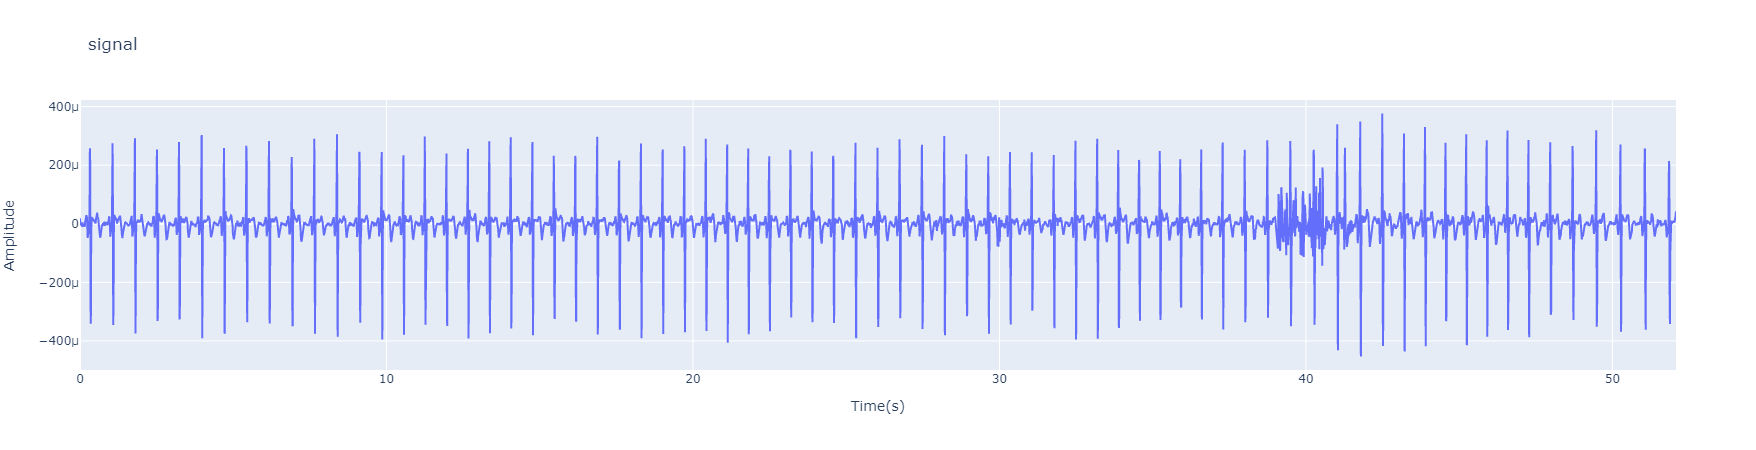

In [6]:
# plot the ppg signal
# Here I'm using plotly which provides zooming feature (https://plot.ly/python)
trace1 = go.Scatter(
    x = df.index/fs,
    y = ppg,
    mode = 'lines'
)

layout = go.Layout(
    title='signal',
    xaxis=dict(title= 'Time(s)'),
    yaxis=dict(title= 'Amplitude'),
)

data = [trace1]
fig= go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)


In [7]:
## Initialization
# N: total No. of samples
# L: number of scales
# alpha: constant factor 
# M: Local Maxima Scalogram matrix (initialize with random numbers)
# M_reshaped: Local Maxima Scalogram matrix, reshaped to the scales of interest.

N =  ppg.shape[0]                           
L = int(2*fs)       
alpha =10;                                
M = alpha + np.abs(np.random.randn(L,N))
M_reshaped =0

print ('N = ', N)
print ('L = ', L)
print ('M = ', M.shape)

N =  5000
L =  192
M =  (192, 5000)


In [8]:
# L: number of scales
# k: scale (frequency resolution)
start = time.time()
for k in range(0, int(L)): 
    start = time.time()
    for i in range(k+1, N-k-1):
        if (ppg[i]>ppg[i-k-1] and ppg[i]>ppg[i+k+1]):
            M[k,i]=0;
total_time = time.time()-start
print(total_time)

0.15698623657226562


In [9]:
# gamma: array of shape L. 
#        by summing all the columns, you get a vector that contains 
#        the information about the scale-dependant distribution of zeros (local maxima)
# chosen: number of chosen scales (rows), which is index of the global minimum 
#         This represents the scale with the most local maxima.

gamma = np.sum(M, axis=1)
chosen = np.argmin(gamma)
print ('number of chosen rows = ', chosen)

plt.figure(figsize=(8,4))
plt.plot(gamma)
plt.title('Finding the scale (row) which holds the global minimum')
plt.ylabel('value of the resulted row-wise sum')
plt.xlabel('scales (L)')
plt.show()

number of chosen rows =  33


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
# M_reshaped: Local Maxima Scalogram matrix, reshaped to the scales of interest.
# standard: shape N 
#           the standard deviation of the reshaped M matrix in the x-axis.

M_reshaped = M[0:chosen,:]
standard = np.std(M_reshaped, axis=0)

In [11]:
# peakLocations: ppg peaks locations in samples.
# peakLocations_time: ppg peaks locations in time (s)
# RR intervals in ms

peakLocations = np.where(standard==0)[0]
peakLocations_time = peakLocations/fs;
RR = np.diff(peakLocations_time) * 1000;  

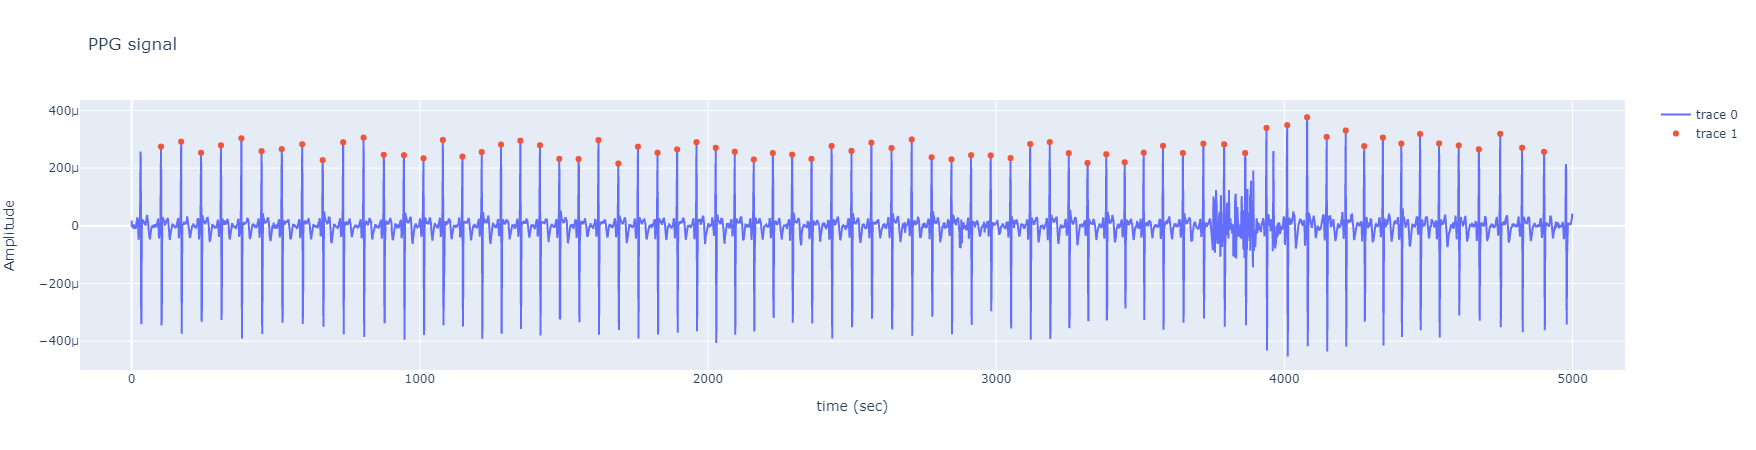

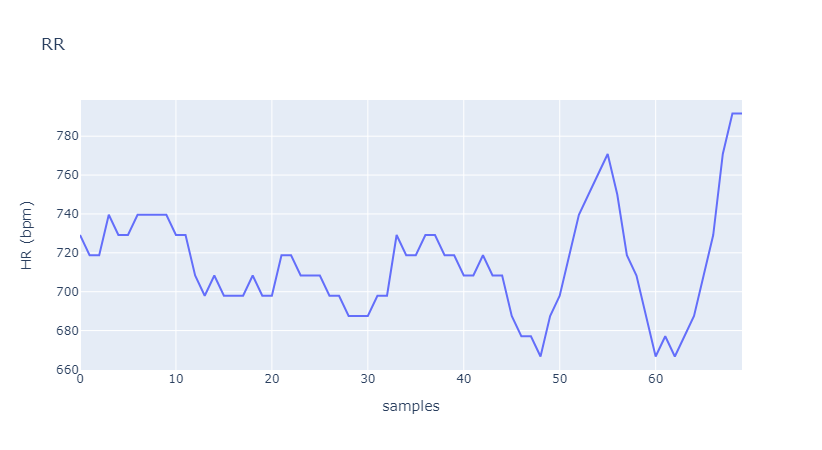

In [12]:
# plot the ppg signal with the peaks locations. (again: using plotly library)
trace1 = go.Scatter(
    x = np.arange(ppg.shape[0]),
    y = ppg,
    mode = 'lines'
)
trace2 = go.Scatter(
    x = peakLocations,
    y = ppg[peakLocations],
    mode = 'markers'
)
layout = go.Layout(
    title='PPG signal',
    xaxis=dict(title= 'time (sec)'),
    yaxis=dict(title= 'Amplitude'),
)

data = [trace1,trace2]

fig= go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

# plot the RR signal.
trace4 = go.Scatter(
    x = np.arange(RR.shape[0]),
    y = RR,
    mode = 'lines'
)
layout = go.Layout(
    title='RR',
    xaxis=dict(title= 'samples'),
    yaxis=dict(title= 'HR (bpm)'),
)

data = [trace4]

fig= go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

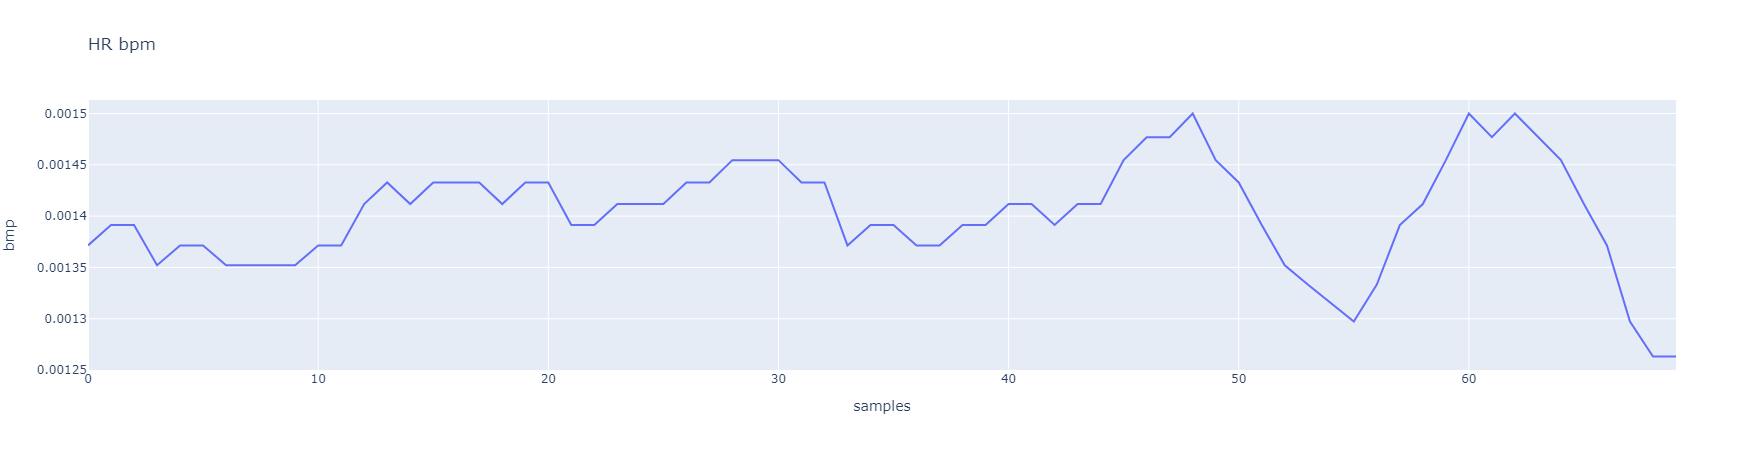

In [13]:
# plot the bpm.
trace1 = go.Scatter(
    x = np.arange(RR.shape[0]),
    y = 1/RR,
    mode = 'lines'
)
layout = go.Layout(
    title='HR bpm',
    xaxis=dict(title= 'samples'),
    yaxis=dict(title= 'bmp'),
)

data = [trace1]

fig= go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [14]:
# For better visualization, slice the M matrix up to some sample.
sample = 1000
ax =plt.figure(figsize=(8,8))
plt.imshow(M_reshaped[:,:sample], aspect=sample/100);
plt.title('Local Maxima Scalogram matrix (LMS)')
plt.ylabel('scale (k)')
plt.xlabel('sample')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'sample')

In [15]:
def time_measurements(RR,x):
    # Parameters: RR: RR intervals in ms
    #        x: threshold in ms, typically: 50
    # return: a dict holds the time domain measurements: pnnx, rmssd (please check the definition of pnnx, rmssd on the table1 above)
    
    # IRI: the difference between RR intervals    

    IRI = np.abs(np.diff(RR))
    n=np.sum(IRI > x)
    pnnx=(n/len(IRI))*100

    rmssd = np.sqrt(np.mean(IRI ** 2))
    
    return dict(zip(['pnnx', 'rmssd'],
                    [pnnx, rmssd]))
  
time_measurements(RR, 50)

{'pnnx': 0.0, 'rmssd': 13.506201235715054}

In [16]:
def freq_measurements(RR, fs, bands, method='periodogram', plotting=True):
    # Estimatation of the power spectral density (PSD).
    # Parameters: RR: RR intervals in ms
    #             fs: sampling frequency of the RR signal (not the ppg)
    #             method: method used to estimate the power spectral density (PSD).
    #             plotting: True if you want to plot the PSD.
    # return: a dict holds some freq domain measurements.
    #         very low frequency (vlf), low frequency (lf), and high frequency (hf) components. 
    #         LF/HF ratio (lf_hf),  normalized vlues of the high and low frequencies (lfnu, hfnu)
    # (please check the definitions in this paper: 
    # the Malik, M., Bigger, J. T., Camm, A. J., Kleiger, R. E., Malliani, A., Moss, A. J., & Schwartz, P. J. (1996). Heart rate variability: Standards of measurement, physiological interpretation, and clinical use. European heart journal, 17(3), 354-381.)
    
    # f: Array of sample frequencies.
    # Pxx_den: Power spectral density or power spectrum of x.
    
    # For implementation functions, refer to: 
    #                  https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.signal.periodogram.html
    #                  https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.signal.welch.html
    #                  https://docs.scipy.org/doc/numpy-1.9.2/reference/generated/numpy.trapz.html#numpy.trapz
    
    # using two methods:
    if method == 'periodogram':
        f, Pxx_den = signal.periodogram(x=RR, fs=fs)
    elif method == 'welch':
        f, Pxx_den = signal.welch(x=RR, fs=fs)
        
    # finding the indices of each band.
    vlf_indices = np.logical_and(f>= bands['vlf'][0], f < bands['vlf'][1])
    lf_indices = np.logical_and(f>= bands['lf'][0], f < bands['lf'][1])
    hf_indices = np.logical_and(f>= bands['hf'][0], f < bands['hf'][1])
    
    # integrate the power spectral density at each band.
    vlf = np.trapz(y=Pxx_den[vlf_indices], x=f[vlf_indices])
    lf = np.trapz(y=Pxx_den[lf_indices], x=f[lf_indices])
    hf = np.trapz(y=Pxx_den[hf_indices], x=f[hf_indices])
    
    total_power = vlf + lf + hf
    lf_hf = lf / hf
    lfnu = (lf / (total_power - vlf)) * 100
    hfnu = (hf / (total_power - vlf)) * 100
    
    if plotting:
        trace1 = go.Scatter(
            x = f,
            y = Pxx_den,
            mode = 'lines'
        )

        layout = go.Layout(
            title='power spectral density  (PSD)',
            xaxis=dict(title= 'Frequency (Hz)'),
            yaxis=dict(title= 'PSD'),
        )

        data = [trace1]
        fig= go.Figure(data=data, layout=layout)
        plotly.offline.iplot(fig)
        
    return dict(zip(['total_power', 'vlf', 'lf', 'hf', 'lf_hf', 'lfnu','hfnu'],
                    [total_power, vlf, lf, hf, lf_hf, lfnu, hfnu]))


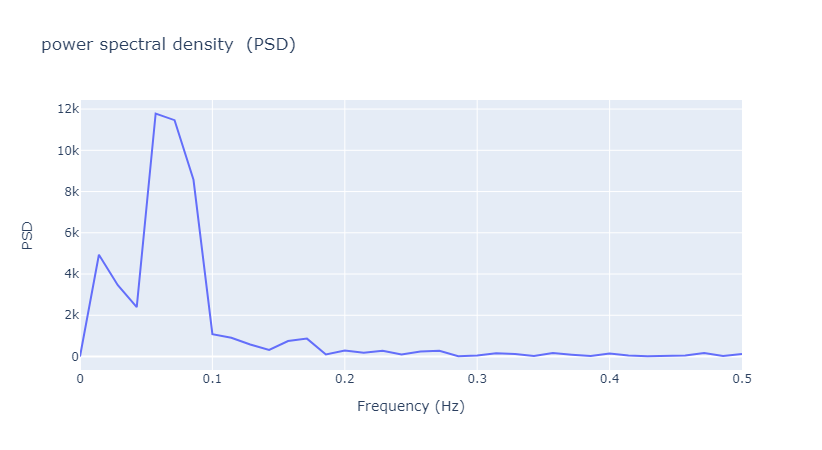

{'total_power': 654.6330965849162,
 'vlf': 95.19996945415812,
 'lf': 510.7378483874591,
 'hf': 48.69527874329885,
 'lf_hf': 10.488446961765133,
 'lfnu': 91.29560328451603,
 'hfnu': 8.704396715483949}

In [17]:
bands = {'vlf': (0, 0.04), 'lf': (0.04, 0.15), 'hf': (0.15, 0.4)}
freq_measurements(RR, 1.0, bands)

C:\Users\alkurdi\.conda\envs\m3x\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning:

nperseg = 256 is greater than input length  = 70, using nperseg = 70



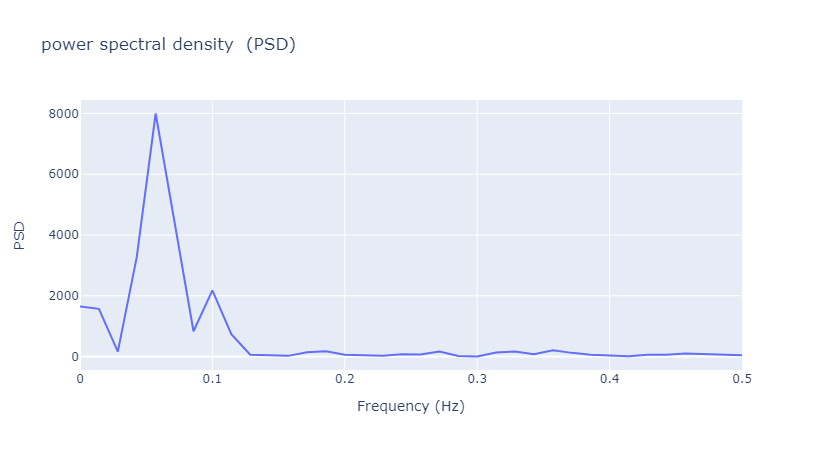

{'total_power': 314.06778603334254,
 'vlf': 35.32071545667271,
 'lf': 256.25451731990063,
 'hf': 22.492553256769227,
 'lf_hf': 11.392860312235996,
 'lfnu': 91.93083779849711,
 'hfnu': 8.06916220150289}

In [18]:
bands = {'vlf': (0, 0.04), 'lf': (0.04, 0.15), 'hf': (0.15, 0.4)}
freq_measurements(RR, 1.0, bands, method='welch')

In [19]:
end = time.time()
print(f'cost= {end-start}s')
print(f'factor={factor}')


cost= 4.567814826965332s
factor=20


In [20]:
plt.plot([5,10,15,16,17,20,25], [19.88,13.41,19.41,0.56,17.11,10.85,10.55])
plt.title('lf_hf vs downsampling factor')
plt.xlabel('factor')
plt.ylabel('lf_hf')
plt.xticks([5,10,15,20,25]);

plt.figure()
plt.plot([5,10,15,16,17,20,25],[251.97, 248.61, 251.43, 506.43, 252.48, 239.22, 247.83])
plt.title('lf vs downsampling factor')
plt.xlabel('factor')
plt.ylabel('lf')
plt.xticks([5,10,15,20,25]);
plt.ylim([230, 260])

plt.figure()
plt.plot([5,10,15,16,17,20,25],[12.67 ,18.52, 12.94, 898.33, 14.75,22.03,23.48])
plt.title('hf vs downsampling factor')
plt.xlabel('factor')
plt.ylabel('hf')
plt.xticks([5,10,15,20,25]);
plt.ylim([0, 30])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.0, 30.0)

# comparisons


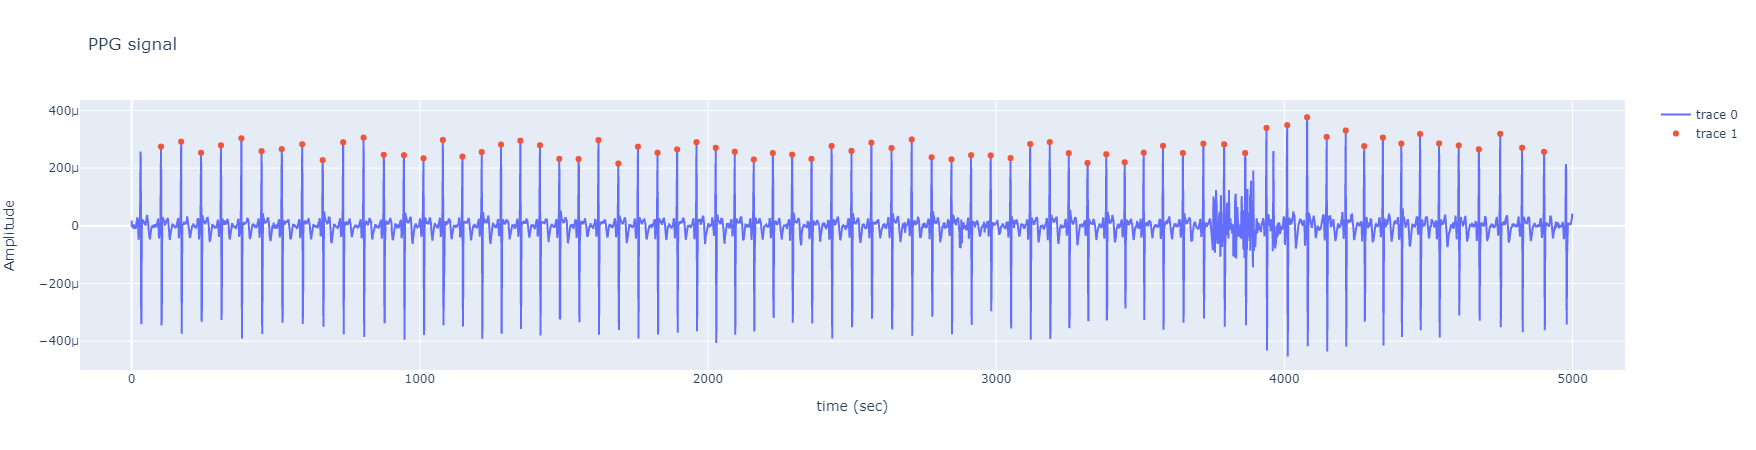

In [21]:
# plot the ppg signal with the peaks locations. (again: using plotly library)
trace1 = go.Scatter(
    x = np.arange(ppg.shape[0]),
    y = ppg,
    mode = 'lines'
)
trace2 = go.Scatter(
    x = peakLocations,
    y = ppg[peakLocations],
    mode = 'markers'
)
layout = go.Layout(
    title='PPG signal',
    xaxis=dict(title= 'time (sec)'),
    yaxis=dict(title= 'Amplitude'),
)

data = [trace1,trace2]

fig= go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [22]:
# plot the ppg signal with the peaks locations. (again: using plotly library)
trace1 = go.Scatter(
    x = np.arange(ppg.shape[0]),
    y = ppg,
    mode = 'lines'
)
trace2 = go.Scatter(
    x = results[0],
    y = ppg[results[0]],
    mode = 'markers'
)
layout = go.Layout(
    title='PPG signal',
    xaxis=dict(title= 'time (sec)'),
    yaxis=dict(title= 'Amplitude'),
)

data = [trace1,trace2]

fig= go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

NameError: name 'results' is not defined

In [ ]:
import wfdb
from wfdb import processing
results = wfdb.processing.find_peaks(ppg.to_numpy())
results[0]

qrs_detection = processing.xqrs_detect(ppg.to_numpy(),1926/20)


In [ ]:
# plot the ppg signal with the peaks locations. (again: using plotly library)
trace1 = go.Scatter(
    x = np.arange(ppg.shape[0]),
    y = ppg,
    mode = 'lines'
)
trace2 = go.Scatter(
    x = qrs_detection,
    y = ppg[qrs_detection],
    mode = 'markers'
)
layout = go.Layout(
    title='PPG signal',
    xaxis=dict(title= 'time (sec)'),
    yaxis=dict(title= 'Amplitude'),
)

data = [trace1,trace2]

fig= go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [ ]:
from scipy import signal

high = 20*2/(1926/20)
#cutoff_freq = [low, high]
b, a = signal.butter(10,  high)
ecg_filt = signal.filtfilt(b, a, ppg)
filt_qrs = processing.xqrs_detect(ecg_filt,1926/20)



In [23]:
# plot the ppg signal with the peaks locations. (again: using plotly library)
trace1 = go.Scatter(
    x = np.arange(ecg_filt.shape[0]),
    y = ecg_filt,
    mode = 'lines'
)
trace2 = go.Scatter(
    x = filt_qrs,
    y = ecg_filt[filt_qrs],
    mode = 'markers'
)
layout = go.Layout(
    title='PPG signal',
    xaxis=dict(title= 'time (sec)'),
    yaxis=dict(title= 'Amplitude'),
)

data = [trace1,trace2]

fig= go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)



NameError: name 'ecg_filt' is not defined

In [ ]:
shifted_peaks = wfdb.processing.correct_peaks(ppg.to_numpy(), qrs_detection, 70,1, peak_dir='compare')
shifted_peaks


In [ ]:
# plot the ppg signal with the peaks locations. (again: using plotly library)
trace0 = go.Scatter(
    x = np.arange(ppg.shape[0]),
    y = ppg,
    mode = 'lines'
)
trace1 = go.Scatter(
    x = qrs_detection,
    y = ppg[qrs_detection],
    mode = 'markers'
)
trace2 = go.Scatter(
    x = shifted_peaks[1::],
    y = ppg[shifted_peaks[1::]],
    mode = 'markers'
)

layout = go.Layout(
    title='PPG signal',
    xaxis=dict(title= 'time (sec)'),
    yaxis=dict(title= 'Amplitude'),
)

data = [trace0,trace1, trace2]

fig= go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [ ]:
#freq_ratio_hybrid( ecg, fs, RR, method, factor = 1):
